In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [25]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [26]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)

<h4>Creating Dictionary Keys</h4>

In [27]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [28]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [29]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [30]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [31]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[0]]
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[new_df[0]]
latest_sel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object

<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [32]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head()
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0
3,ECS010230200078,010000425766,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0
4,ECS010230200248,010000444765,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-19,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


In [33]:
# Interpolate using spline interpolation

# Remove duplicated dates and cost rows
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Remove features that are not important
sel_feat = ['POD','RATE']
sel_df = sel_df[sel_feat]

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, sel_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='spline', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(2)

df_interpolated.head(10)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.00
1,2005-10-04,390.07
2,2005-10-05,390.06
3,2005-10-06,390.06
4,2005-10-07,390.00
5,2005-10-08,390.05
6,2005-10-09,390.05
7,2005-10-10,390.05
8,2005-10-11,390.04
9,2005-10-12,390.04


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6376 non-null   datetime64[ns]
 1   RATE    6376 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.4 KB


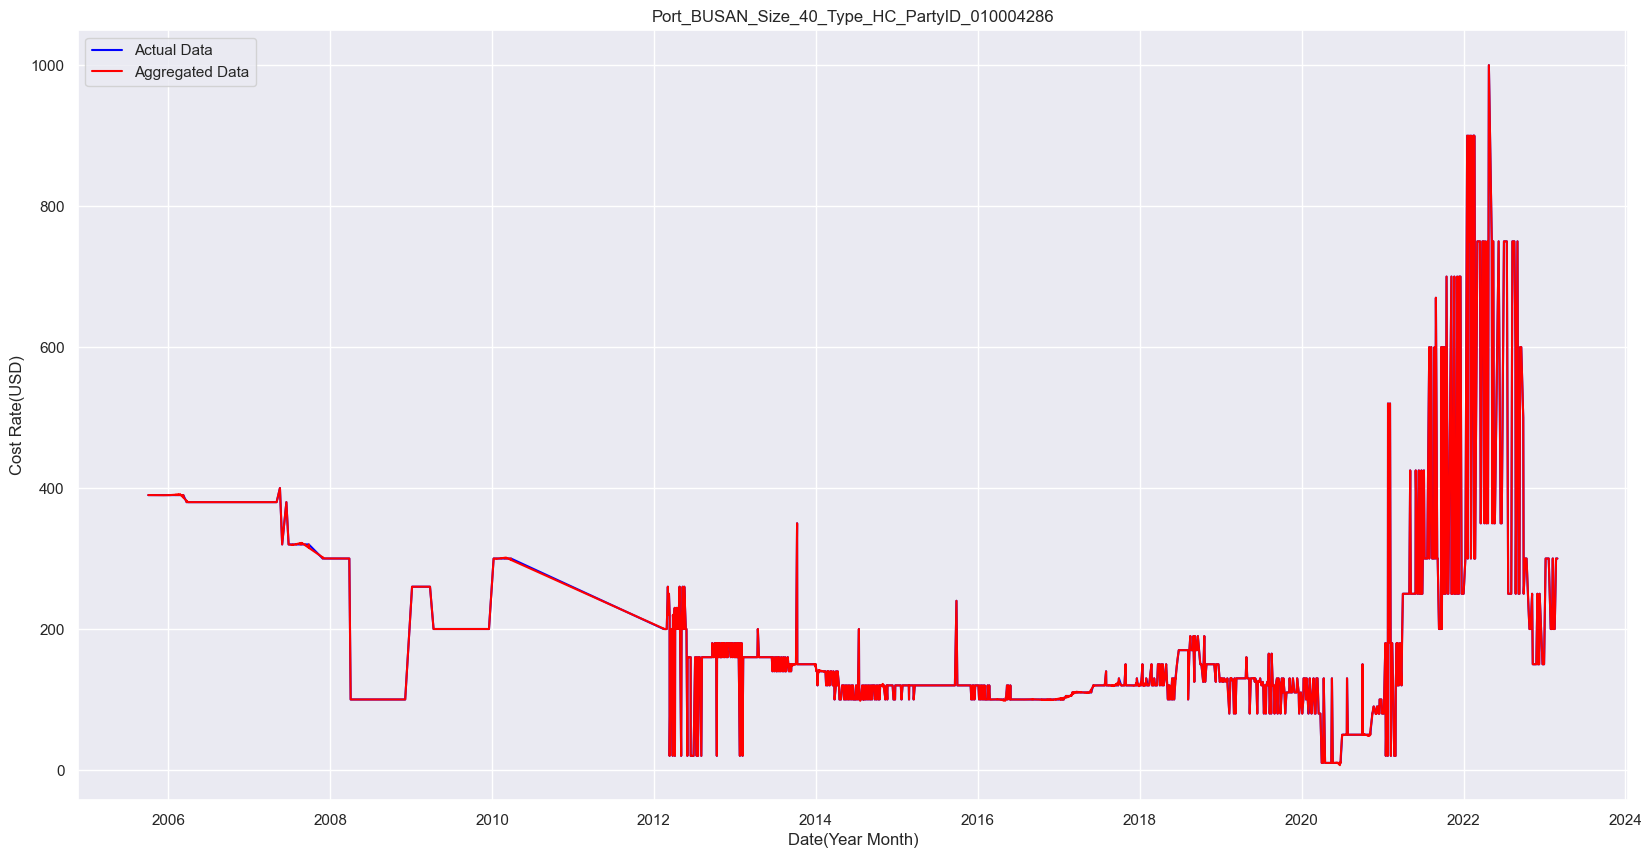

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='red', label="Aggregated Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [35]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>LSTM Regression<h4>

In [83]:
# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=16, verbose=2, validation_data=(testX, testY))
    return model, history
def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 10 epochs...
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 1, 100)            41600     
                                                                 
 lstm_48 (LSTM)              (None, 100)               80400     
                                                                 
 dense_43 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
279/279 - 5s - loss: 0.0027 - val_loss: 0.0058 - 5s/epoch - 19ms/step
Epoch 2/10
279/279 - 1s - loss: 1.6659e-04 - val_loss: 0.0049 - 1s/epoch - 4ms/step
Epoch 3/10
279/279 - 1s - loss: 1.5886e-04 - val_loss: 0.0046 - 1s/epoch - 4ms/step
Epoch 4/10
279/279 - 1s - loss: 1.48

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

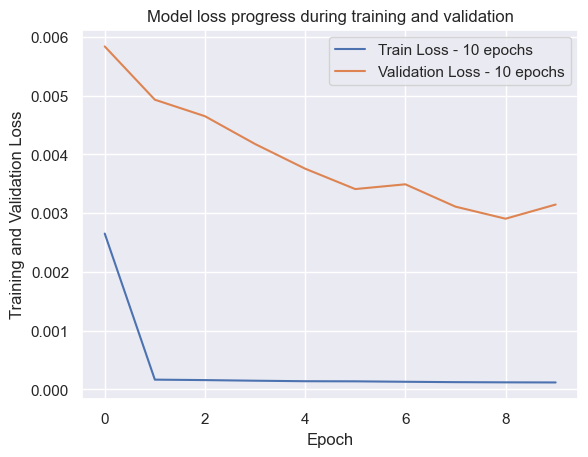

60/60 [==============================] - 0s 1ms/step
Train Score: 13.38 RMSE for 10 epochs
Test Score: 55.71 RMSE for 10 epochs
Training for 50 epochs...
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 1, 100)            41600     
                                                                 
 lstm_50 (LSTM)              (None, 100)               80400     
                                                                 
 dense_44 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
279/279 - 6s - loss: 0.0030 - val_loss: 0.0052 - 6s/epoch - 21ms/step
Epoch 2/50
279/279 - 1s - loss: 1.6016e-04 - val_loss: 0.0051 - 1s/epoch - 4

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

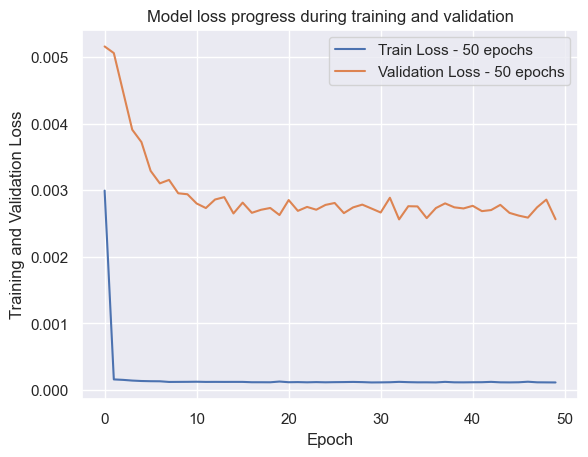

60/60 [==============================] - 0s 2ms/step
Train Score: 13.98 RMSE for 50 epochs
Test Score: 50.29 RMSE for 50 epochs
Training for 100 epochs...
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 1, 100)            41600     
                                                                 
 lstm_52 (LSTM)              (None, 100)               80400     
                                                                 
 dense_45 (Dense)            (None, 1)                 101       
                                                                 
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
279/279 - 5s - loss: 0.0029 - val_loss: 0.0054 - 5s/epoch - 18ms/step
Epoch 2/100
279/279 - 1s - loss: 1.6006e-04 - val_loss: 0.0047 - 1s/epoch 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

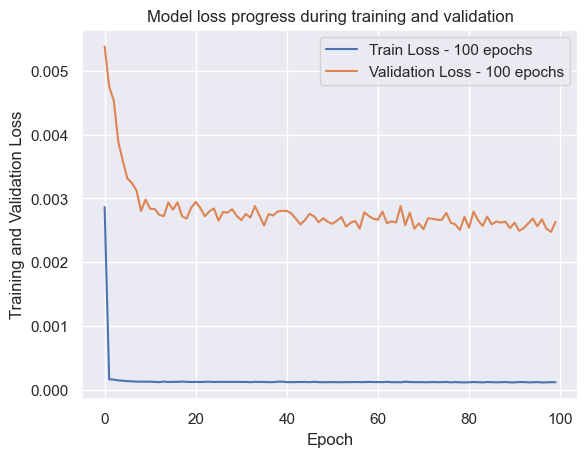

60/60 [==============================] - 0s 2ms/step
Train Score: 10.45 RMSE for 100 epochs
Test Score: 50.93 RMSE for 100 epochs
     Train RMSE  Test RMSE
10    13.379847  55.712315
50    13.982711  50.289644
100   10.446621  50.931328


In [85]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_interpolated['RATE'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [10, 50, 100]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)


<h4>Modeling For ARIMA<h4>

In [68]:
df_arima1 = df_interpolated[['POD','RATE']].copy()
df_arima1.set_index('POD', inplace=True)
df_arima1.head()
df_arima1.info()

,RATE
POD,
2005-10-03,390.00
2005-10-04,390.07
2005-10-05,390.06
2005-10-06,390.06
2005-10-07,390.00


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6376 entries, 2005-10-03 to 2023-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    6376 non-null   float64
dtypes: float64(1)
memory usage: 99.6 KB


In [86]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Apply logarithm transformation to 'Rate' column
df_arima1['RATE'] = np.log(df_arima1['RATE'])

# Fit an auto_arima model
arima_model1 = pm.auto_arima(df_arima1['RATE'], start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False, 
                            d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model1.summary())

# Split the data into training and test data
train_size1 = int(len(df_arima1) * 0.7)
train1, test1 = df_arima1[0:train_size1], df_arima1[train_size1:]

# Train the model on the training data
arima_model1.fit(train1)

# Forecast
train_forecast1, conf_int_train1 = arima_model1.predict(n_periods=len(train1), return_conf_int=True)
test_forecast1, conf_int_test1 = arima_model1.predict(n_periods=len(test1), return_conf_int=True)

# Reverse the logarithm transformation
train1['RATE'] = np.exp(train1['RATE'])
test1['RATE'] = np.exp(test1['RATE'])
train_forecast1 = np.exp(train_forecast1)
test_forecast1 = np.exp(test_forecast1)
conf_int_train1 = np.exp(conf_int_train1)
conf_int_test1 = np.exp(conf_int_test1)

# Calculate the RMSE
RMSE_ARIMA_train1 = np.sqrt(mean_squared_error(train1['RATE'], train_forecast1))
print("Train RMSE: %.3f" % RMSE_ARIMA_train1)
RMSE_ARIMA_test1 = np.sqrt(mean_squared_error(test1['RATE'], test_forecast1))
print("Test RMSE: %.3f" % RMSE_ARIMA_test1)


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24281.748, Time=4.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23915.303, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23980.568, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23989.286, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23917.303, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24280.062, Time=5.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-23935.568, Time=3.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-24012.492, Time=2.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24000.045, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24283.774, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-23991.286, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23982.568, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24282.114, Time=1.89 sec
 ARIMA(1,1,2

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Train RMSE: 0.646
Test RMSE: 0.942


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_17764\3539220472.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['RATE'] = np.exp(train1['RATE'])
C:\Users\Aloysius Wong\AppData\Local\Temp\ip